In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import time
from timeit import default_timer as timer
import torch
from torch.autograd import Variable

import numpy as np
import pickle
import pathlib

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor

cuda available


In [2]:
from core.SimpleConvNet import SimpleConvNet
from core.GraphConvNet2 import GraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from util.plot_embedding import plot_embedding_subplot
from util.draw_random_subset import draw_random_subset
from util.evaluation_metrics import evaluate_net_metrics

In [3]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [4]:
train_dir = {'mnist': 'set_20000_mnist_tsne.pkl', 
             'usps': 'set_7291_usps_tsne.pkl', 
             '20news': '20news_train_tsne.pkl', 
             'yux': 'yux_train_tsne_shuffle.pkl',
             'fasttext': 'fasttext_train_tsne.pkl', 
             'mnist_embeddings': 'mnist_embeddings_train.pkl', 
             'imagenet': 'imagenet_train.pkl'}

test_dir = {'mnist': 'set_100_mnist_spectral_size_200_500.pkl', 
            'usps': 'set_100_usps_spectral_size_200_500.pkl', 
            '20news': None, 
            'yux': None,
            'fasttext': None, 
            'mnist_embeddings': None, 
            'imagenet': None}

max_train_size = {'mnist': 20000,
                  'usps': 7291, 
                  '20news': 3944, 
                  'yux': 7000, 
                  'fasttext': 3000, 
                  'mnist_embeddings': 5000, 
                  'imagenet': 3350}

In [5]:
task_parameters = {}
task_parameters['dataset'] = 'imagenet'
task_parameters['net_type'] = 'graph_net'
task_parameters['reduction_method'] = 'preprocessed_tsne'
task_parameters['loss_function'] = 'composite_loss'
task_parameters['n_components'] = 2
task_parameters['train_dir'] = train_dir[task_parameters['dataset']]
task_parameters['test_dir'] = test_dir[task_parameters['dataset']]
task_parameters['val_flag'] = False

net_parameters = {}
net_parameters['n_components'] = task_parameters['n_components']
net_parameters['D'] = 512 # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers
net_parameters['n_channels'] = 1 # for conv net
net_parameters['n_units_1'] = net_parameters['n_units_2'] = net_parameters['H'] # for conv net

In [6]:
if task_parameters['net_type'] == 'graph_net':
    net = GraphConvNet2(net_parameters)
elif task_parameters['net_type'] == 'conv_net':
    net = SimpleConvNet(net_parameters)
if torch.cuda.is_available():
    net.cuda()
# print(net)

In [7]:
# optimization parameters
opt_parameters = {}
opt_parameters['learning_rate'] = 0.00075   # ADAM
opt_parameters['max_iters'] = 200   
opt_parameters['batch_iters'] = 10
opt_parameters['max_train_size'] = max_train_size[task_parameters['dataset']]  
opt_parameters['save_flag'] = True

if 2==1: # fast debugging
    opt_parameters['max_iters'] = 5 
    opt_parameters['batch_iters'] = 1
    opt_parameters['save_flag'] = False

opt_parameters['decay_rate'] = 1.25   

In [8]:
if opt_parameters['save_flag']: 
    checkpoint_interval = opt_parameters['max_iters']/5
    result_dir = 'results/'
    subdirs = [x[0] for x in os.walk(result_dir) if task_parameters['dataset'] in x[0]]
    run_number = str(len(subdirs) + 1) + '/'
    checkpoint_root = result_dir + task_parameters['dataset'] +'_'+ task_parameters['reduction_method'] + run_number
    pathlib.Path(checkpoint_root).mkdir(exist_ok=True) # create the directory if it doesn't exist
    print('Saving results into: {}'.format(checkpoint_root))

Saving results into: results/imagenet_preprocessed_tsne1/


## Prepare data

In [9]:
# Pre-processed train data
parent_dir = os.path.abspath('..')
data_dir = parent_dir + '/data/' + task_parameters['dataset'] +'/'
with open(data_dir + task_parameters['train_dir'], 'rb') as f:
    [inputs, labels, X_emb] = pickle.load(f)

In [10]:
print(inputs.shape)
print(len(labels))
print(X_emb.shape)

(3350, 512)
3350
(3350, 2)


In [11]:
all_train_data = []
num_train_samples = 0
while num_train_samples <= opt_parameters['max_train_size']:
    # Draw a random training batch of variable size
    num_samples = np.random.randint(200, 500)
    inputs_subset = inputs[num_train_samples:num_train_samples+num_samples]
    X_emb_subset = X_emb[num_train_samples:num_train_samples+num_samples]
    
    if task_parameters['val_flag']:
        labels_subset = labels[num_train_samples:num_train_samples+num_samples]
    else:
        labels_subset = []
    
    # Package into graph block
    G = DataEmbeddingGraph(inputs_subset, labels_subset, method=None)
    G.target = X_emb_subset # replace target with pre-computed embeddings
    
    all_train_data.append(G)
    num_train_samples += num_samples  

In [12]:
if all_train_data[-1].data.shape[0] < 200:
    print('Removing the last block...')
    all_train_data = all_train_data[:-1]

Removing the last block...


In [13]:
dataset_sizes = [G.data.shape[0] for G in all_train_data]
print("Dataset sizes = {}".format(dataset_sizes))
print("Total number of samples = {}".format(sum(dataset_sizes)))

Dataset sizes = [398, 321, 356, 498, 347, 272, 358, 422, 323]
Total number of samples = 3295


In [14]:
# Test set
if task_parameters['val_flag']:
    with open(data_dir + task_parameters['test_dir'], 'rb') as f:
        [all_test_data] = pickle.load(f)

## Train net

In [15]:
# Optimization parameters
learning_rate = opt_parameters['learning_rate']
max_iters = opt_parameters['max_iters']
batch_iters = opt_parameters['batch_iters']
decay_rate = opt_parameters['decay_rate']

# Optimizer
global_lr = learning_rate
global_step = 0
lr = learning_rate
optimizer = net.update(lr) 

# Statistics
t_start = time.time()
t_start_total = time.time()
average_loss_old = 1e10
running_loss = 0.0
running_total = 0
tab_results = []
    
for iteration in range(max_iters):
    net.train()
    for G in all_train_data:
        # Forward pass
        y_pred = net.forward(G)

        # Target embedding matrix
        y_true = G.target
        y_true = Variable(torch.FloatTensor(y_true).type(dtypeFloat) , requires_grad=False) 

        # Compute overall loss 
        if task_parameters['loss_function'] == 'pairwise_loss':
            loss = net.pairwise_loss(y_pred, y_true, G.adj_matrix)
        elif task_parameters['loss_function'] == 'composite_loss':
            loss1 = net.loss(y_pred, y_true)
            loss2 = net.pairwise_loss(y_pred, y_true, G.adj_matrix)
            loss = 0.5*loss1 + 0.5*loss2
            
        loss_train = loss.data[0]
        running_loss += loss_train
        running_total += 1

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # learning rate, print results
    if not iteration%batch_iters:

        # time
        t_stop = time.time() - t_start
        t_start = time.time()

        # update learning rate 
        average_loss = running_loss/ running_total
        if average_loss > 0.99* average_loss_old:
            lr /= decay_rate
        average_loss_old = average_loss
        optimizer = net.update_learning_rate(optimizer, lr)
        running_loss = 0.0
        running_total = 0

        # print results
        print('\niteration= %d, loss(%diter)= %.8f, lr= %.8f, time(%diter)= %.2f' %
              (iteration, batch_iters, average_loss, lr, batch_iters, t_stop))
            
        # validate on test set
        #######################
        if task_parameters['val_flag']:
            trustworthiness, one_nn, five_nn, time_elapsed = evaluate_net_metrics(all_test_data, net)
            print("Trust = {:.4f}, 1-NN = {:.4f}, 5-NN = {:.4f}, time to compute = {:.2f}s".format(trustworthiness, one_nn, five_nn, time_elapsed))
            tab_results.append([iteration, average_loss, trustworthiness, one_nn, five_nn, time.time()-t_start_total])
        else:
            tab_results.append([iteration, average_loss, time.time()-t_start_total])
            
    if opt_parameters['save_flag'] and not (iteration+1)%checkpoint_interval:
        filename = checkpoint_root + task_parameters['net_type'] + str(int((iteration+1)/checkpoint_interval)) + '.pkl'
        save_checkpoint({
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, filename)

/home/leowyaoyang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



iteration= 0, loss(10iter)= 1507.63110352, lr= 0.00075000, time(10iter)= 2.98

iteration= 10, loss(10iter)= 949.99609375, lr= 0.00075000, time(10iter)= 23.20

iteration= 20, loss(10iter)= 139.55670166, lr= 0.00075000, time(10iter)= 23.21

iteration= 30, loss(10iter)= 75.31067657, lr= 0.00075000, time(10iter)= 22.87

iteration= 40, loss(10iter)= 46.96107483, lr= 0.00075000, time(10iter)= 23.17

iteration= 50, loss(10iter)= 28.25922012, lr= 0.00075000, time(10iter)= 22.45

iteration= 60, loss(10iter)= 17.57114983, lr= 0.00075000, time(10iter)= 23.05

iteration= 70, loss(10iter)= 12.52256203, lr= 0.00075000, time(10iter)= 22.97

iteration= 80, loss(10iter)= 9.12787151, lr= 0.00075000, time(10iter)= 23.24

iteration= 90, loss(10iter)= 6.47460365, lr= 0.00075000, time(10iter)= 23.53

iteration= 100, loss(10iter)= 6.39448309, lr= 0.00075000, time(10iter)= 23.52

iteration= 110, loss(10iter)= 5.13635015, lr= 0.00075000, time(10iter)= 23.46

iteration= 120, loss(10iter)= 4.93423462, lr= 0.000

In [16]:
# Save metadata 
if opt_parameters['save_flag']:
    metadata_filename = checkpoint_root + "experiment_metadata.txt"
    with open(metadata_filename, 'w') as f:
        f.write('-----------------------\n')
        f.write('\n'.join(["%s = %s" % (k,v) for k,v in task_parameters.items()]))
        
        f.write('\n-----------------------\n')
        f.write('\n'.join(["%s = %s" % (k,v) for k,v in net_parameters.items()]))
        
        f.write('\n-----------------------\n')
        f.write('\n'.join(["%s = %s" % (k,v) for k,v in opt_parameters.items()]))

In [17]:
# Save logs 
if opt_parameters['save_flag']:
    logs_filename = checkpoint_root + "experiment_results.pkl"
    with open(logs_filename, 'wb') as f:
        pickle.dump(tab_results, f)

In [18]:
# Plot results
iterations = [res[0] for res in tab_results]
loss_score = [float(res[1]) for res in tab_results]
max_loss = max(loss_score)
loss_score = [res/max_loss for res in loss_score] # normalise losses

if task_parameters['val_flag']:
    trust_score = [res[2] for res in tab_results]
    one_nn_score = [res[3] for res in tab_results]
    five_nn_score = [res[4] for res in tab_results]

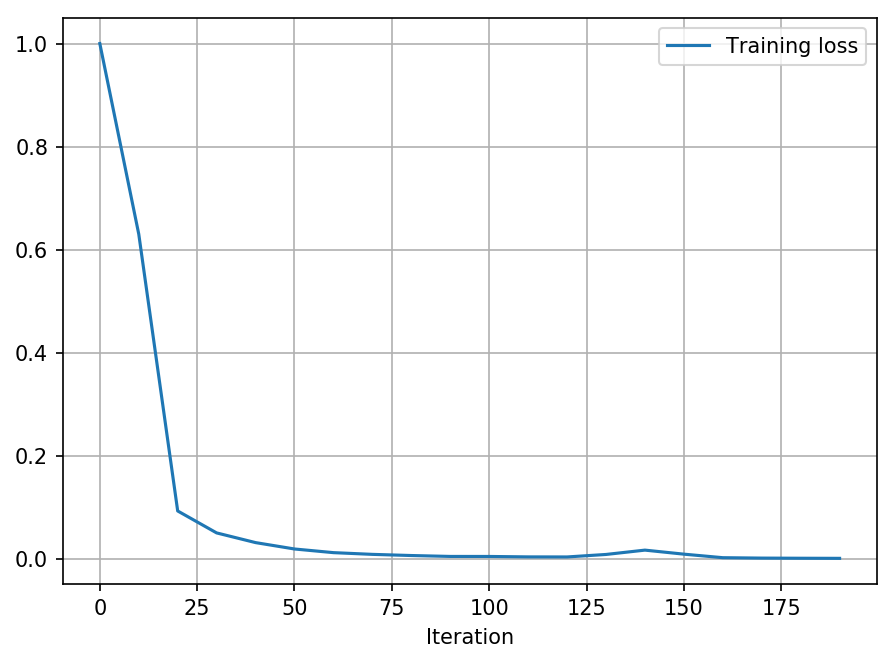

In [19]:
f, axarr = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(7,5), dpi=150)
plt.plot(iterations, loss_score, label='Training loss')

if task_parameters['val_flag']:
    plt.plot(iterations, trust_score, label='Trustworthiness')
    plt.plot(iterations, one_nn_score, label='1-NN accuracy')
    plt.plot(iterations, five_nn_score, label='5-NN accuracy')

plt.grid()
plt.legend()
plt.xlabel('Iteration')
if opt_parameters['save_flag']:
    plot_filename = checkpoint_root + task_parameters['dataset'] +'_'+ task_parameters['reduction_method'] + "_plot.png"
    plt.savefig(plot_filename)

In [20]:
# Continue execution only if val_flag is True
assert task_parameters['val_flag'], 'Stopped further execution because val_flag is off'

AssertionError: Stopped further execution because val_flag is off

## On test data

In [ ]:
# inputs, labels = draw_random_subset(test_data, num_samples=500)
# G = DataEmbeddingGraph(inputs, labels, task_parameters['reduction_method'])
# net_time_start = timer()
# if torch.cuda.is_available():   
#     y_pred = net.forward(G).cpu().detach().numpy()
# else:    
#     y_pred = net.forward(G).detach().numpy()
# net_time_end = timer()

# f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
# reduction_title = task_parameters['reduction_method'] + "\n time elapsed = {:.2f}s".format(G.time_to_compute) 
# cnn_title = "Graph CNN" + "\n time elapsed = {:.2f}s".format(net_time_end - net_time_start) 
# plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), reduction_title)
# plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), cnn_title)

In [ ]:
# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

In [ ]:
def plot_embedding_subplot(ax, X, labels=None, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if labels is not None:
        for i in range(X.shape[0]):
            ax.text(X[i, 0], X[i, 1], str(labels[i]),
                    color=colormap[labels[i]],
                    fontdict={'weight': 'bold', 'size': 9})

    ax.set_xticks([]), ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

In [ ]:
f, axarr = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 10))
int_labels = [int(l) for l in labels]
plot_embedding_subplot(axarr, X_emb, labels=int_labels, title='tsne')

In [ ]:
from core.DimReduction import DimReduction

f, axarr = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(20, 10.5))
dim_red = DimReduction(n_components=2)

for i in range(4):
    G = all_train_data[i]
    int_labels = [int(l) for l in G.labels]
    X = G.data.view(G.data.shape[0], -1).numpy()
    
    # tsne
    X_emb1 = dim_red.fit_transform(X, 'tsne', labels)
    plot_embedding_subplot(axarr[0,i], X_emb1, labels=int_labels, title='tsne')
    
    # ground truth
    plot_embedding_subplot(axarr[1,i], G.target, labels=int_labels, title='ground_truth')
    
    # Net
    if torch.cuda.is_available():   
        y_pred = net.forward(G).cpu().detach().numpy()
    else:    
        y_pred = net.forward(G).detach().numpy()
    plot_embedding_subplot(axarr[2,i], y_pred, labels=int_labels, title='tsne_net')